# IPTS-28662


In [130]:
import sys
import os
sys.path.append(os.path.expanduser('~/git/analysis_playground/reduction'))

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [2]:
import mantid
import mantid.simpleapi as api
mantid.kernel.config.setLogLevel(3)

ConfigService-[Information] Unable to locate directory at: /etc/mantid/instrument
ConfigService-[Information] This is Mantid version 6.3.0 revision g3629346a7f5
ConfigService-[Information] running on jupyter-node01.sns.gov starting 2022-12-08T13:49Z
ConfigService-[Information] Properties file(s) loaded: /usr/local/anaconda/envs/sans/bin/Mantid.properties, /etc/mantid.local.properties, /SNS/users/m2d/.mantid/Mantid.user.properties
ConfigService-[Information] Unable to locate directory at: /etc/mantid/instrument
FrameworkManager-[Notice] Welcome to Mantid 6.3.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.3
FrameworkManager-[Information] Version check disabled.
GitHubApiHelper-[Information] Making unauthenticated calls to GitHub
GitHubApiHelper-[Information] Making unauthenticated calls to GitHub
DownloadInstrument-[Notice] All instrument definitions up to date
ConfigService-[Error] loggin

In [3]:
print(mantid.__version__)
print(sys.version)

6.3.0
3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]


In [4]:
import importlib
import event_reduction
import template
import peak_finding
importlib.reload(peak_finding)
importlib.reload(template)
importlib.reload(event_reduction)

<module 'event_reduction' from '/SNS/users/m2d/git/analysis_playground/reduction/event_reduction.py'>

In [323]:
data_dir = '/SNS/REF_L/IPTS-28662/shared/autoreduce'
#template_path = os.path.join(data_dir, 'template_si_12072022.xml')
template_path = os.path.join(data_dir, 'template_si_12122022.xml')
template_path = '/SNS/REF_L/IPTS-29524/shared/autoreduce/template_with_offset.xml'
reduced_path = os.path.join(data_dir, 'REFL_198382_combined_data_auto.txt')

reduced_std = np.loadtxt(reduced_path).T

# Gather information

In [328]:
run_number = 198859
ws_sc = api.LoadEventNexus("REF_L_%s" % run_number)


# Get the sequence number
sequence_number = 1
if ws_sc.getRun().hasProperty("sequence_number"):
    sequence_number = ws_sc.getRun().getProperty("sequence_number").value[0]
print("seq number", sequence_number)
# Load the template
template_data = template.read_template(template_path, sequence_number)

ws_db = api.LoadEventNexus("REF_L_%s" % template_data.norm_file)

offset=template_data.angle_offset

thi_value = ws_sc.getRun()['thi'].value[0]
tthd_1 = ws_sc.getRun()['tthd'].value[0]
theta = np.fabs(ws_sc.getRun()['ths'].value[0]) + offset

theta_1 = np.fabs(tthd_1 - thi_value) / 2. + offset

_wl = ws_sc.getRun()['LambdaRequest'].value[0]
print('wl=%g; tthd=%g; ths=%g [%g] offset=%g' % (_wl, tthd_1, theta, theta_1, offset))

theta = theta * np.pi / 180.

peak = template_data.DataPeakPixels
peak_bck = [template_data.DataBackgroundRoi[0], template_data.DataBackgroundRoi[1]]

direct_peak = template_data.NormPeakPixels
peak_center = (direct_peak[0]+direct_peak[1])/2.0
print("Peak center %g" % peak_center)

seq number 1
wl=15; tthd=-1.19964; ths=0.671356 [0.665757] offset=0.07
Peak center 142


# Plot detector with peak selection found in the template

(100.0, 180.0)

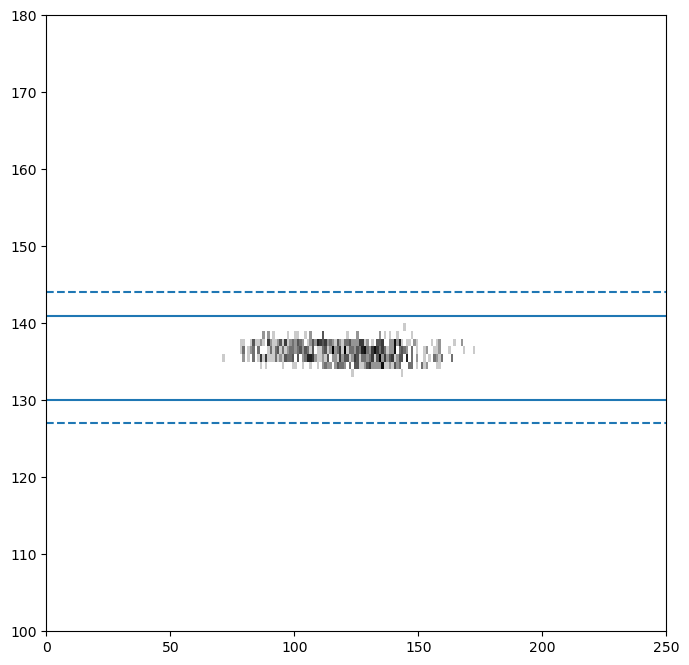

In [329]:
tof_min = ws_sc.getTofMin()
tof_max = ws_sc.getTofMax()
_ws = api.Rebin(InputWorkspace=ws_sc, Params="%s,200,%s" % (tof_min, tof_max))
y=_ws.extractY()
x=_ws.extractX()
y = np.reshape(y, (256, 304, y.shape[1]))

_x_vs_y = np.sum(y, axis=2)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.pcolormesh(np.arange(256), np.arange(304), np.log(_x_vs_y.T), cmap="Greys")
l = mlines.Line2D([0, 304], [peak[0], peak[0]], linestyle='-')
ax.add_line(l)
l = mlines.Line2D([0, 304], [peak[1], peak[1]], linestyle='-')
ax.add_line(l)
l = mlines.Line2D([0, 304], [peak_bck[0], peak_bck[0]], linestyle='--')
ax.add_line(l)
l = mlines.Line2D([0, 304], [peak_bck[1], peak_bck[1]], linestyle='--')
ax.add_line(l)

ax.set_xlim([0,250])
ax.set_ylim([100,180])

Center: 135.775	 Width: 1.65418 [130 143]


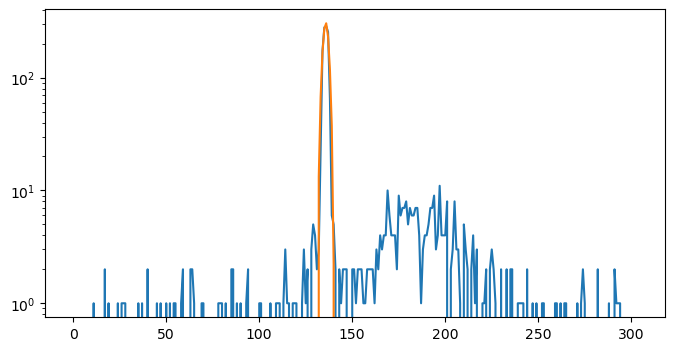

In [330]:
importlib.reload(peak_finding)

x_min=peak[0]-25
x_max=peak[1]+25

tof, _x, _y = peak_finding.process_data(ws_sc, summed=True, tof_step=200)

peak_center = np.argmax(_y)
center, width, fit = peak_finding.fit_signal_flat_bck(_x, _y, x_min=x_min, x_max=x_max, center=peak_center)
print("Center: %g\t Width: %g [%g %g]" % (center, width, np.ceil(center-4*width), np.ceil(center+4*width)))

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(_x, _y)
plt.plot(_x[x_min:x_max], fit.best_fit)

plt.yscale('log')


# Reduction


198859
wl=15; ths=0.671356; offset=0.07

198860
wl=12.386; ths=0.670058; offset=0.07

198861
wl=9.74; ths=0.669896; offset=0.07

198862
wl=7.043; ths=0.670382; offset=0.07

198863
wl=4.25; ths=0.670058; offset=0.07

198864
wl=4.25; ths=1.25207; offset=0.07

198865
wl=4.25; ths=2.41348; offset=0.07

198866
wl=4.25; ths=4.70841; offset=0.07


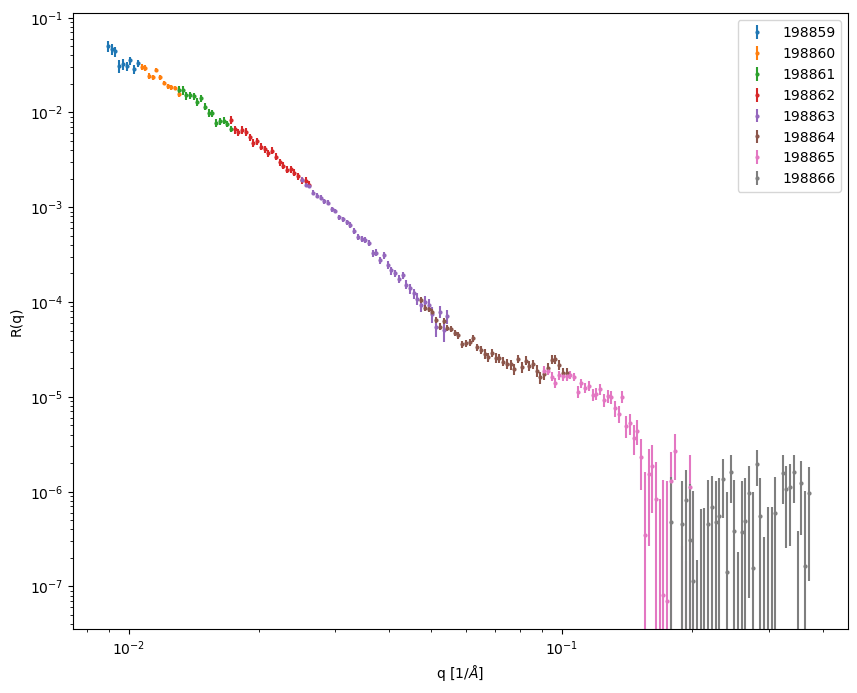

Q resolution = 0.02738351655529674


In [331]:
importlib.reload(template)
importlib.reload(event_reduction)

#qz_mid, refl, d_refl = template.process_from_template(run_number, template_path)
pre_cut = 1
post_cut = 1

qz_all = []
refl_all = []
d_refl_all = []

first_run = None

fig, ax = plt.subplots(figsize=(10,8))

first_run = None
resolution = 0.028

#for run_number in range(198382, 198390):
#for run_number in range(198391, 198399):
#for run_number in range(198409, 198417):
#for run_number in [198409, 198410, 198411, 198412, 198413, 198414, 198415, '198416+198417']:
#for run_number in range(198418, 198426):
#for run_number in range(198427, 198435):
#for run_number in range(198436, 198444):
#for run_number in range(198444, 198452):
#for run_number in range(198452, 198460):
#for run_number in range(198461, 198469):
#for run_number in range(198470, 198478):
#for run_number in range(198478, 198486):
#for run_number in range(198488, 198496):
#for run_number in range(198498, 198506):
#for run_number in range(198506, 198514):
#for run_number in range(198517, 198525):
#for run_number in range(198527, 198535):

# The following uses new DBs
#for run_number in range(198536, 198544):
#for run_number in range(198545, 198553):
#for run_number in range(198553, 198561):
#for run_number in range(198562, 198570):
#for run_number in range(198571, 198578):
#for run_number in range(198579, 198587):
#for run_number in range(198589, 198597):
#for run_number in range(198604, 198611):
#for run_number in range(198612, 198619):
#for run_number in range(198620, 198627):
#for run_number in range(198628, 198635):
#for run_number in range(198635, 198643):
#for run_number in range(198643, 198650):
#for run_number in range(198651, 198659):
#for run_number in range(198660, 198668):
#for run_number in range(198668, 198676):
#for run_number in range(198676, 198682):

# Last IPTS
#for run_number in range(198682, 198689):
#for run_number in range(198689, 198696):
#for run_number in range(198696, 198703):
#for run_number in range(198703, 198710):
#for run_number in range(198710, 198717):
#for run_number in range(198717, 198724):
#for run_number in range(198724, 198730):   ###
#for run_number in range(198730, 198737):
#for run_number in range(198737, 198744):
#for run_number in range(198744, 198751):
#for run_number in range(198751, 198758):
#for run_number in range(198758, 198765):
#for run_number in range(198765, 198773):
#for run_number in range(198774, 198782):

# Misaligned cells
#for run_number in range(198850, 198850+7):
for run_number in range(198859, 198859+8):
    
    print('\n%s' % run_number)
    ws_sc = api.Load("REF_L_%s" % run_number)
    qz_mid, refl, d_refl = template.process_from_template_ws(ws_sc, template_path)

    if first_run is None:
        first_run = run_number
        resolution = event_reduction.compute_resolution(ws_sc)

    idx = np.fabs(refl) > 0
    qz_mid = qz_mid[idx][pre_cut:-post_cut]
    refl = refl[idx][pre_cut:-post_cut]
    d_refl = d_refl[idx][pre_cut:-post_cut]
    
    plt.errorbar(qz_mid, refl, yerr=d_refl, markersize=4, marker='.', linestyle='', label=run_number)
 
    for i in range(len(qz_mid)-1, -1, -1):
        qz_all.append(qz_mid[i])
        refl_all.append(refl[i])
        d_refl_all.append(d_refl[i])

qz_all = np.asarray(qz_all)
refl_all = np.asarray(refl_all)
d_refl_all = np.asarray(d_refl_all)
idx = np.argsort(qz_all)

qz_all = np.take_along_axis(qz_all, idx, axis=None)
refl_all = np.take_along_axis(refl_all, idx, axis=None)
d_refl_all = np.take_along_axis(d_refl_all, idx, axis=None)


plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()



print("Q resolution = %s" % resolution)

/SNS/REF_L/IPTS-29524/shared/autoreduce/REFL_198859_combined_data_auto.txt


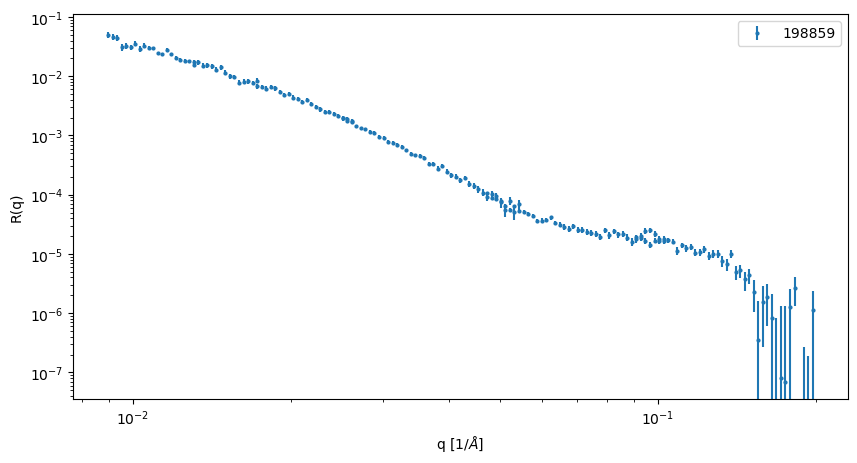

Writing file: /SNS/REF_L/IPTS-28662/shared/autoreduce/../r198859.txt


In [327]:
for ipts in [28662, 29487, 29524]:
    reduced_path = os.path.join('/SNS/REF_L/IPTS-%s/shared/autoreduce' % ipts, 'REFL_%s_combined_data_auto.txt' % first_run)
    if os.path.isfile(reduced_path):
        print(reduced_path)
        ar_data = np.loadtxt(reduced_path).T
        break

reduced_path = os.path.join(data_dir, '..', 'final', "r%s.txt" % first_run)
previous_exists = False
if os.path.isfile(reduced_path):
    _data = np.loadtxt(reduced_path).T
    previous_exists = True


fig, ax = plt.subplots(figsize=(10,5))
plt.errorbar(qz_all, refl_all, yerr=d_refl_all, markersize=4, marker='.', linestyle='', label=first_run)
#plt.errorbar(ar_data[0], ar_data[1], yerr=ar_data[2], markersize=4, marker='.', linestyle='', label='AR')
if previous_exists:
    plt.errorbar(_data[0], _data[1], yerr=_data[2], markersize=4, marker='', linestyle='-', label='old')


plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

if previous_exists and len(_data[1])==len(refl_all):
    delta = np.fabs(_data[1]-refl_all)/refl_all*100
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(qz_all, delta)

    plt.xlabel('q [$1/\AA$]')
    plt.ylabel('$\Delta$R/R [%]')
    ax.set_yscale('linear')
    ax.set_xscale('log')
    plt.show()
    plt.show()


dq = qz_all * resolution
output_file = os.path.join(data_dir, '..', "r%s.txt" % first_run)
np.savetxt(output_file, np.asarray([qz_all, refl_all, d_refl_all, dq]).T)
print("Writing file: %s" % output_file)


In [321]:
delta_theta_f = np.arctan((141.45-135.9)*0.0007 / 1.83) / 2.0 * 180 / np.pi
print("offset = %g" % delta_theta_f)

offset = 0.060818
